In [1]:
from Parameters import ModelParams
from Mass_Loss_Class import MassLoss
from Fractionation_Class import Fractionation
from Model_Data_Loader import ModelDataLoader
from Results_Handler import ResultsHandler

Excluded: RS_flow (3.46e+07) < REUV (4.95e+08) for planet mass=0.25 M_earth, radius=0.73 R_earth.
Excluded: RS_flow (6.92e+07) < REUV (5.75e+08) for planet mass=0.50 M_earth, radius=0.87 R_earth.
Excluded: RS_flow (2.43e+08) < REUV (6.82e+08) for planet mass=1.00 M_earth, radius=1.04 R_earth.
Excluded: RS_flow (6.99e+08) < REUV (8.13e+08) for planet mass=2.00 M_earth, radius=1.25 R_earth.


/Users/mvalatsou/PhD/Repos/Mass-Loss/Mass_Loss_Class.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_launch**2 + cs_use**2)) / (2. * rho_EUV * cs_eq**2)


Iteration 4: Converged with flux total = 1.4127088618601473e-09, phi_O = 2.5920328093076727e-16, phi_H = 1.4127086026568664e-09.
Planet 0 Fractionation Results: phi_O = 2.5920328093076727e-16, phi_H = 1.4127086026568664e-09, x_O = 3.6695930136375804e-07
Iteration 3: Converged with flux total = 1.1379298060193844e-09, phi_O = 1.2473302566839959e-17, phi_H = 1.1379297935460818e-09.
Planet 1 Fractionation Results: phi_O = 1.2473302566839959e-17, phi_H = 1.1379297935460818e-09, x_O = 2.1922798115637592e-08
Iteration 3: Converged with flux total = 9.611052093711241e-10, phi_O = 9.75614234554768e-19, phi_H = 9.611052083955099e-10.
Planet 2 Fractionation Results: phi_O = 9.75614234554768e-19, phi_H = 9.611052083955099e-10, x_O = 2.0301923785918915e-09
Iteration 3: Converged with flux total = 8.365704805194602e-10, phi_O = 1.1028966357027812e-19, phi_H = 8.365704804091706e-10.
Planet 3 Fractionation Results: phi_O = 1.1028966357027812e-19, phi_H = 8.365704804091706e-10, x_O = 2.636709426235908

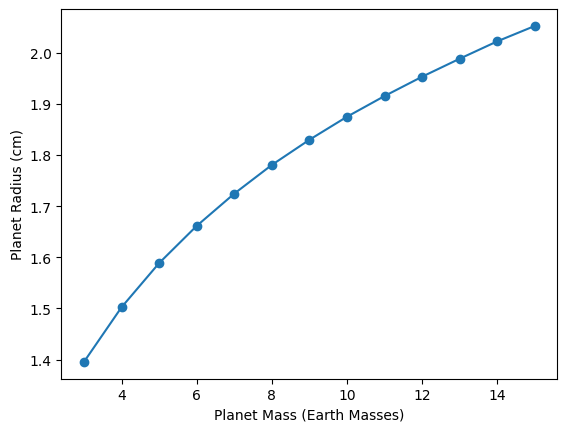

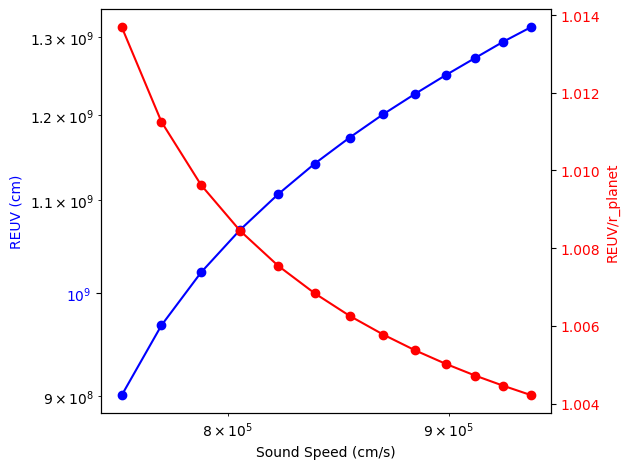

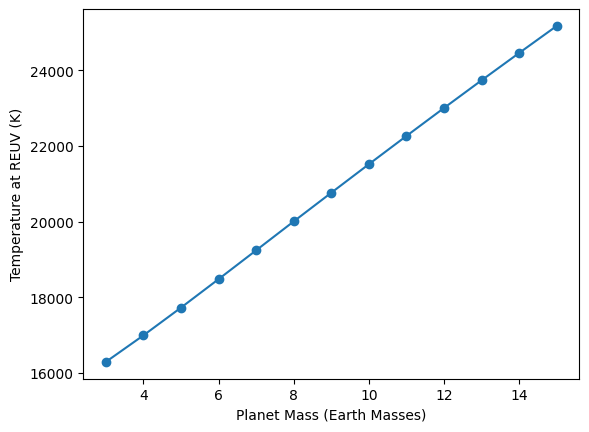

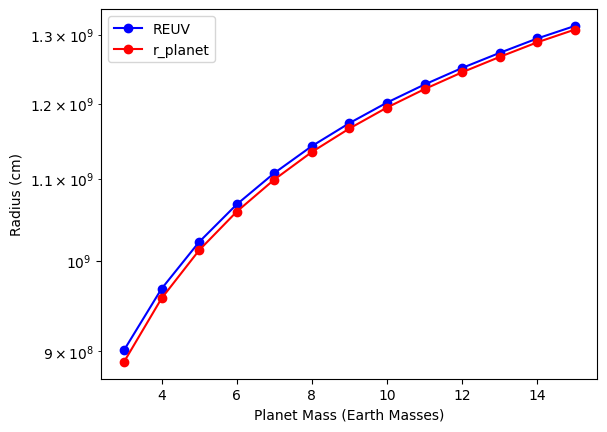

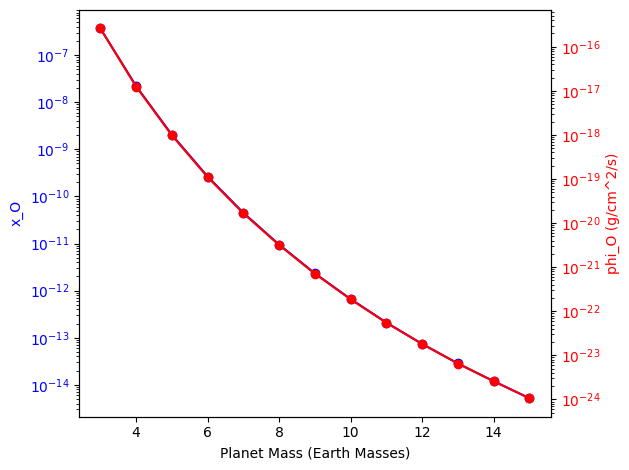

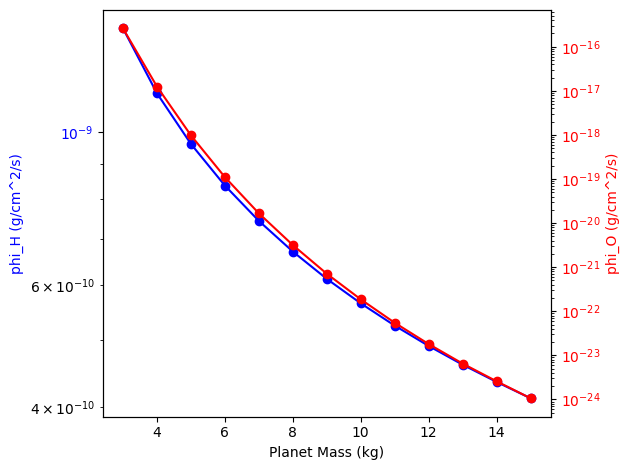

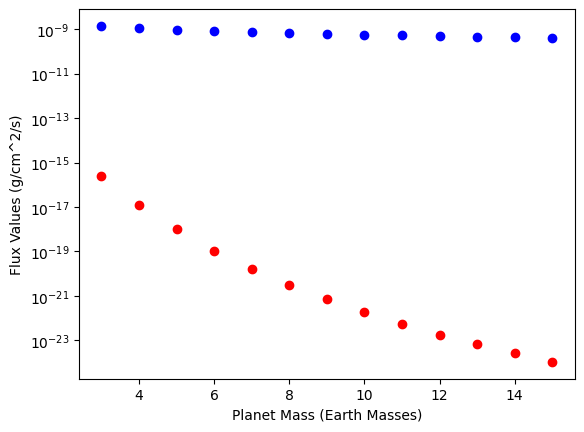

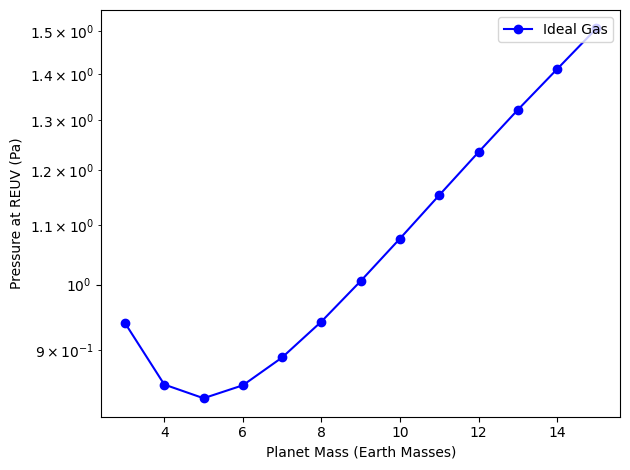

In [2]:
def main():

    # initialize parameters and classes
    params = ModelParams()
    base_path = '/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/CW/critical_WMF/gridmin295/'
    data_loader = ModelDataLoader(base_path)
    mass_loss = MassLoss(params)
    fractionation = Fractionation(params)

    # load data
    m_planet = [0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    water_percent = [x / 10 for x in range(1, 81)]
    radii_list, mass_list, teq_list = data_loader.load_model_data(m_planet, water_percent)

    # mass loss model
    results = mass_loss.compute_mass_loss_parameters(mass_list, radii_list, teq_list)

    # fractionation model
    all_results = []
    for planet_index, result in enumerate(results):
        m_planet = result['mass']
        r_planet = result['radius']
        Teq = result['Teq']
        REUV = result['REUV']
        cs = result['cs']
        Mdot = result['Mdot']
        RS_flow = result['RS_flow']
        rho_flow = result['rho_flow']
        rho_EUV = result['rho_EUV']

        T_REUV, b_i, mass_difference, flux_total, reservoir_ratio = fractionation.preprocess_fractionation_params(cs, REUV, Mdot, Teq)
        phi_O, phi_H, x_O = fractionation.iterative_fractionation(flux_total, REUV, m_planet, T_REUV, b_i, mass_difference, reservoir_ratio)
        print(f"Planet {planet_index} Fractionation Results: phi_O = {phi_O}, phi_H = {phi_H}, x_O = {x_O}")

        # gather all data in one list of dictionaries, one for each planet
        planet_results = {
            'm_planet': m_planet,
            'r_planet': r_planet,
            'Teq': Teq,
            'REUV': REUV,
            'cs': cs,
            'Mdot': Mdot,
            'RS_flow': RS_flow,
            'rho_flow': rho_flow,
            'rho_EUV': rho_EUV,
            'T_REUV': T_REUV,
            'phi_H': phi_H,
            'phi_O': phi_O,
            'x_O': x_O
        }

        all_results.append(planet_results)
        
    # calculate pressures at EUV
    pressures_ideal = mass_loss.calculate_pressure_ideal_gas(all_results)

    # save and/or plot results
    # ResultsHandler.save_results(all_results, "fractionation_results.pkl")
    ResultsHandler.plot_m_planet_r_planet(all_results)
    ResultsHandler.plot_cs_REUV(all_results)
    ResultsHandler.plot_T_REUV_m_planet(all_results)
    ResultsHandler.plot_REUV_r_planet_vs_m_planet(all_results)
    ResultsHandler.plot_xO_phiO_vs_m_planet(all_results)
    ResultsHandler.plot_phiH_phiO_vs_m_planet(all_results)
    ResultsHandler.plot_phiH_phiO_vs_m_planet_color(all_results)
    ResultsHandler.plot_pressure_vs_m_planet(pressures_ideal)

if __name__ == "__main__":
   main()